In [123]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from tensorflow import data

In [124]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6194197965567352402, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14742444489581862372
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 907751022919386053
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32039642727
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8611099686685878167
 physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0"]

In [125]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
import multiprocessing
import shutil

In [126]:
import re
import nltk
import swifter

In [127]:
MODEL_NAME = 'toxic_model'
TRAIN_DATA_FILES_PATTERN = 'data/processed/train-*.tsv'
VALID_DATA_FILES_PATTERN = 'data/processed/valid-*.tsv'
RESUME_TRAINING = True
MULTI_THREADING = True
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
CLASS_TO_LABEL = {'toxic': 0, 'non-toxic': 1}
BERT_PRETRAINED_DIR = '/home/luis.magana/BERT/uncased_L-12_H-768_A-12/'
TARGET_LABELS = ['0', '1']

In [128]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 42
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

# Set the output directory for saving model file
# Optionally, set a GCP bucket location
OUTPUT_DIR = './toxic_models/'


In [129]:
MAX_DOCUMENT_LENGTH = 220
PAD_WORD = '#=KS=#'
HEADER_DEFAULTS = [['NA'], ['NA'], ['NA']]
TARGET_NAME = 'target'
WEIGHT_COLUNM_NAME = 'weight' #This will not be used for now

In [168]:
test_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/test.csv')
train_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/train.csv')

In [131]:
train_df = train_df.fillna(0)
train_df['target'] = train_df['target'].apply(lambda x: 0 if x <= 0.5 else 1)

In [132]:
symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'

In [133]:
import re
import contractions #pip install contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions.contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions.contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [134]:
from nltk.tokenize.treebank import TreebankWordTokenizer

isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}


def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

def handle_contractions(x):
    x = expand_contractions(x)
    return x.split(' ')

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

In [169]:
import swifter

train_df['comment_text'] = train_df['comment_text'].swifter.allow_dask_on_strings(enable=True).apply(lambda x:preprocess(x))
test_df['comment_text'] = test_df['comment_text'].swifter.allow_dask_on_strings(enable=True).apply(lambda x:preprocess(x))

In [136]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.001)

In [137]:
val_df.shape

(1805, 45)

In [138]:
train_df.head(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
1410170,5842313,0,To Daniel Sage of Centennial - the KKK did n...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,370650,approved,0,0,0,1,0,0.0,0,4
803472,5103997,0,"Another day , another WWIII advocacy piece fr...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,325163,rejected,0,0,0,7,0,0.0,0,4
1197005,5578826,0,""" Dare "" needs to be resigned as a non worki...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,354489,approved,0,0,0,1,0,0.0,0,4


In [139]:
train_df.target.value_counts(normalize=True)

0    0.941032
1    0.058968
Name: target, dtype: float64

In [140]:
train_df.head(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
1410170,5842313,0,To Daniel Sage of Centennial - the KKK did n...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,370650,approved,0,0,0,1,0,0.0,0,4
803472,5103997,0,"Another day , another WWIII advocacy piece fr...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,325163,rejected,0,0,0,7,0,0.0,0,4
1197005,5578826,0,""" Dare "" needs to be resigned as a non worki...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,354489,approved,0,0,0,1,0,0.0,0,4


In [141]:
HEADER = ["id", "target", "comment_text"]

In [142]:
from bert import tokenization
import os


VOCAB_LIST_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_LIST_FILE, do_lower_case=False)

In [170]:
#train_df['comment_text'] = train_df['comment_text'].swifter.allow_dask_on_strings().apply(lambda x: ' '.join(tokenizer.tokenize(str(x))))
test_df['comment_text'] = test_df['comment_text'].swifter.allow_dask_on_strings().apply(lambda x: ' '.join(tokenizer.tokenize(str(x))))


In [144]:
val_df['comment_text'] = val_df['comment_text'].swifter.allow_dask_on_strings().apply(lambda x: ' '.join(tokenizer.tokenize(str(x))))


0    0.988081
1    0.011919
Name: comment_text, dtype: float64

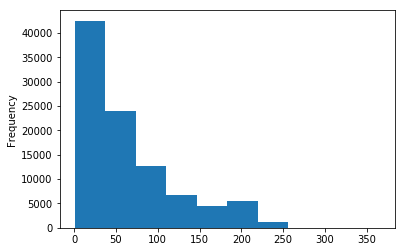

In [171]:
s = test_df['comment_text'].apply(lambda x: len(x.split(' ')))
s.plot(kind='hist')
s.apply(lambda x: 0 if x <= 220 else 1).value_counts(normalize=True)

In [154]:
train_df = train_df[HEADER]
val_df = val_df[HEADER]

train_df.to_csv('./data/processed/train-data.tsv', sep='\t', index=False, header=False)
val_df.to_csv('./data/processed/valid-data.tsv', sep='\t', index=False, header=False)
test_df.to_csv('./data/processed/test-data.tsv', sep='\t', index=False, header=False)

In [155]:
def parse_tsv_row(tsv_row):
    """
    This function assumes that the text has already been cleaned and tokenized. 
    """
    data = tf.decode_csv(tsv_row, record_defaults=HEADER_DEFAULTS, field_delim='\t')
    features = dict(zip(HEADER, data))
    target = features.pop(TARGET_NAME)
    # giving more weight to "spam" records are the are only 13% of the training set
    # features[WEIGHT_COLUNM_NAME] =  tf.cond( tf.equal(target,'spam'), lambda: 6.6, lambda: 1.0 ) 
    features[WEIGHT_COLUNM_NAME] = tf.cond(tf.equal(target, '1'), lambda: 6.6, lambda: 1.0 )
    return features, target

def parse_label(label_string_tensor):
    """
    Takes a tensor string containg the labeled class and returns a one-hot vector representation.
    """
    table = tf.contrib.lookup.index_table_from_tensor(tf.constant(TARGET_LABELS))
    return table.lookup(label_string_tensor)

In [156]:
def input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=1,
                 batch_size=200):
    """
    Input Function for tensorflow estimator. Returns the tensor features and 
    one-hot representation of the target class.
    """
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    buffer_size = 2 * batch_size + 1
   
    print("\n", "* data input_fn:")
    print("===========================================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Thread Count: {}".format(num_threads))
    print("Shuffle: {}".format(shuffle))
    print("===========================================", "\n")

    file_names = tf.matching_files(files_name_pattern)
    dataset = data.TextLineDataset(filenames=file_names)
    
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
        
    dataset = dataset.map(lambda tsv_row: parse_tsv_row(tsv_row), 
                          num_parallel_calls=num_threads)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.prefetch(buffer_size)
    
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()
    return features, parse_label(target)

In [101]:
def process_text(text_feature): 
    """
    The text features will be transformed into a word id vector. 
    
    in  ---> ['a misty ridge uprises from the surge <UNK> <UNK> ... <UNK>']
    out ---> [27 39 40 41 42  1 43  0  0 ... 0]
    """
    #with tf.device("/device:XLA_CPU:0"):
    CLS = tf.fill(tf.shape(text_feature), "[CLS]")
    SEP = tf.fill(tf.shape(text_feature), "[SEP]")   
    text_feature = tf.strings.join([CLS, text_feature, SEP], separator=' ')
    # Load vocabolary lookup table to map word => word_id
    vocab_table = tf.contrib.lookup.index_table_from_file(vocabulary_file=VOCAB_LIST_FILE, 
                                                          num_oov_buckets=1, default_value=-1)
    # Split text to words -> this will produce sparse tensor with variable-lengthes (word count) entries
    words = tf.string_split(text_feature)
    # Convert sparse tensor to dense tensor by padding each entry to match the longest in the batch
    dense_words = tf.sparse_tensor_to_dense(words, default_value=PAD_WORD)
    # Convert word to word_ids via the vocab lookup table
    word_ids = vocab_table.lookup(dense_words)
    # Create a word_ids padding
    padding = tf.constant([[0,0],[0,MAX_DOCUMENT_LENGTH]])
    # Pad all the word_ids entries to the maximum document length
    word_ids_padded = tf.pad(word_ids, padding)
    word_ids_padded = tf.dtypes.cast(word_ids_padded, dtype=tf.dtypes.int32)
    word_id_vector = tf.slice(word_ids_padded, [0,0], [-1, MAX_DOCUMENT_LENGTH])
    # Create Mask
    input_mask = tf.where(word_id_vector > 0, tf.ones_like(word_id_vector, 
                                                           dtype=tf.dtypes.int32), word_id_vector)
    # Create Seg IDs
    segment_ids = tf.zeros(tf.shape(input_mask), dtype=tf.dtypes.int32)
    # Return the final word_id_vector
    return word_id_vector, input_mask, segment_ids

In [157]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels, weights=None):
    """Creates a classification model."""

    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)
        
        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
        
        loss = tf.losses.sparse_softmax_cross_entropy(
            logits=logits, labels=labels, 
            weights=weights
        )
        #loss = tf.nn.weighted_cross_entropy_with_logits(labels, logits, pos_weight=weights)
        return (loss, predicted_labels, log_probs)

In [195]:
def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    num_labels = params.num_labels
    learning_rate = params.learning_rate
    num_train_steps = params.num_train_steps
    num_warmup_steps = params.num_warmup_steps

    input_ids, input_mask, segment_ids  = process_text(features["comment_text"])


    if mode == tf.estimator.ModeKeys.PREDICT:
        is_predicting = True
        
        (predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, labels, num_labels)
        
        predictions = {
            'probabilities': log_probs,
            'labels': predicted_labels
        }
        export_outputs = {
            'prediction': tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(mode, 
                                          predictions=predictions, 
                                          export_outputs=export_outputs)
    
    else:
        is_predicting = False
        
        # weights
        weights = features[WEIGHT_COLUNM_NAME]
        
        (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, labels, num_labels, weights=weights)

        train_op = bert.optimization.create_optimizer(
            loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

        # Calculate evaluation metrics.
        def metric_fn(labels, predicted_labels, log_probs):
            accuracy = tf.metrics.accuracy(labels, predicted_labels)
            probs = tf.reduce_max(tf.exp(log_probs), axis=-1, keepdims=True)
            f1_score = tf.contrib.metrics.f1_score(
                labels,
                probs)
            return {
                "eval_accuracy": accuracy,
                "f1_score": f1_score,
            }
        if mode == tf.estimator.ModeKeys.TRAIN:
            return tf.estimator.EstimatorSpec(mode=mode,
                                              loss=loss,
                                              train_op=train_op)
        else:
            eval_metrics = metric_fn(labels, predicted_labels, log_probs)
            return tf.estimator.EstimatorSpec(mode=mode,
                                              loss=loss,
                                              eval_metric_ops=eval_metrics)

In [226]:
# Compute # train and warmup steps from batch size
TRAIN_SIZE = 1809000
TOTAL_STEPS = int(TRAIN_SIZE / BATCH_SIZE * NUM_TRAIN_EPOCHS)
WARMUP_STEPS = int(TOTAL_STEPS * WARMUP_PROPORTION)
EVAL_AFTER_SEC = 600

In [227]:
print("""Total number of steps is {0}. 
         Total number of warmup steps  is {1}.""".format(TOTAL_STEPS, WARMUP_STEPS))

Total number of steps is 43071. 
         Total number of warmup steps  is 4307.


In [228]:
hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_TRAIN_EPOCHS,
    batch_size = BATCH_SIZE,
    num_labels = len(TARGET_LABELS),
    num_train_steps = TOTAL_STEPS,
    num_warmup_steps = WARMUP_STEPS,
    learning_rate = LEARNING_RATE,
    model_dir = OUTPUT_DIR
)

In [229]:
session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
session_conf.gpu_options.allow_growth = True
session_conf.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
session_conf.intra_op_parallelism_threads = multiprocessing.cpu_count()

run_config = tf.estimator.RunConfig(
    session_config=session_conf,
    log_step_count_steps=500,
    save_checkpoints_steps=100,
    tf_random_seed=17081992,
    model_dir=OUTPUT_DIR
)

In [230]:
def serving_input_fn():
    """
    Serving input function, should contain a receiver_tensor with the same features as the input during training, 
    this function will also be used during validation.
    """
    receiver_tensor = {
      'comment_text': tf.placeholder(tf.string, [None])
    }
    features = {
      key: tensor
      for key, tensor in receiver_tensor.items()
    }
    return tf.estimator.export.ServingInputReceiver(
        features, receiver_tensor)

In [231]:
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: input_fn(
        TRAIN_DATA_FILES_PATTERN,
        mode = tf.estimator.ModeKeys.TRAIN,
        num_epochs=NUM_TRAIN_EPOCHS,
        batch_size=BATCH_SIZE
    ),
    max_steps=hparams.num_train_steps,
    hooks=None
)

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: input_fn(
        VALID_DATA_FILES_PATTERN,
        mode=tf.estimator.ModeKeys.EVAL,
        batch_size=BATCH_SIZE
    ),
    exporters=[tf.estimator.LatestExporter( #LatestExporter or BestExporter
        name="predict", # the name of the folder in which the model will be exported to under export
        serving_input_receiver_fn=serving_input_fn,
        exports_to_keep=1,
        as_text=True)],
    steps=None,
    throttle_secs = EVAL_AFTER_SEC
)

In [232]:
def create_estimator(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=model_fn,
                                  params=hparams,
                                  config=run_config)
    print("Estimator Type: {}".format(type(estimator)))
    return estimator

estimator = create_estimator(run_config, hparams)

INFO:tensorflow:Using config: {'_model_dir': './toxic_models/', '_tf_random_seed': 17081992, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': intra_op_parallelism_threads: 40
gpu_options {
  allow_growth: true
}
allow_soft_placement: true
log_device_placement: true
graph_options {
  optimizer_options {
    global_jit_level: ON_1
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efd71dcf470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0627 10:36:54.652136 139679930693440 estimator.py:201] Using config: {'_model_dir': './toxic_models/', '_tf_random_seed': 17081992, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': intra_op_parallelism_threads: 40
gpu_options {
  allow_growth: true
}
allow_soft_placement: true
log_device_placement: true
graph_options {
  optimizer_options {
    global_jit_level: ON_1
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 500, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efd71dcf470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Estimator Type: <class 'tensorflow_estimator.python.estimator.estimator.Estimator'>


In [233]:
#if not RESUME_TRAINING:
#print("Removing previous artifacts...")
#shutil.rmtree(OUTPUT_DIR, ignore_errors=True)   
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

import logging

# get TF logger
log = logging.getLogger('tensorflow')

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
fh = logging.FileHandler('tensorflow.log')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

tf.estimator.train_and_evaluate(
        estimator=estimator,
        train_spec=train_spec, 
        eval_spec=eval_spec
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Experiment started at 14:36:56
.......................................
INFO:tensorflow:Not using Distribute Coordinator.


I0627 10:36:56.850668 139679930693440 estimator_training.py:185] Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


I0627 10:36:56.855462 139679930693440 training.py:610] Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 100 or save_checkpoints_secs None.


I0627 10:36:56.859523 139679930693440 training.py:698] Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 100 or save_checkpoints_secs None.



 * data input_fn:
Input file(s): data/processed/train-*.tsv
Batch size: 42
Epoch Count: 1
Mode: train
Thread Count: 40
Shuffle: True

INFO:tensorflow:Calling model_fn.


I0627 10:36:56.958705 139679930693440 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0627 10:36:59.161143 139679930693440 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0627 10:37:08.497107 139679930693440 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0627 10:37:08.501667 139679930693440 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0627 10:37:10.198913 139679930693440 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./toxic_models/model.ckpt-42976


I0627 10:37:10.206092 139679930693440 saver.py:1270] Restoring parameters from ./toxic_models/model.ckpt-42976


INFO:tensorflow:Running local_init_op.


I0627 10:37:14.249520 139679930693440 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0627 10:37:14.526021 139679930693440 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 42976 into ./toxic_models/model.ckpt.


I0627 10:37:21.569036 139679930693440 basic_session_run_hooks.py:594] Saving checkpoints for 42976 into ./toxic_models/model.ckpt.


INFO:tensorflow:loss = 0.0675094, step = 42976


I0627 10:37:48.065519 139679930693440 basic_session_run_hooks.py:249] loss = 0.0675094, step = 42976


INFO:tensorflow:Saving checkpoints for 43071 into ./toxic_models/model.ckpt.


I0627 10:39:14.345851 139679930693440 basic_session_run_hooks.py:594] Saving checkpoints for 43071 into ./toxic_models/model.ckpt.



 * data input_fn:
Input file(s): data/processed/valid-*.tsv
Batch size: 42
Epoch Count: 1
Mode: eval
Thread Count: 40
Shuffle: False

INFO:tensorflow:Calling model_fn.


I0627 10:39:16.991114 139679930693440 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0627 10:39:20.037435 139679930693440 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0627 10:39:28.100937 139679930693440 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-06-27T14:39:28Z


I0627 10:39:28.122597 139679930693440 evaluation.py:257] Starting evaluation at 2019-06-27T14:39:28Z


INFO:tensorflow:Graph was finalized.


I0627 10:39:29.419227 139679930693440 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./toxic_models/model.ckpt-43071


I0627 10:39:29.427072 139679930693440 saver.py:1270] Restoring parameters from ./toxic_models/model.ckpt-43071


INFO:tensorflow:Running local_init_op.


I0627 10:39:33.134473 139679930693440 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0627 10:39:33.414460 139679930693440 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-06-27-14:39:49


I0627 10:39:49.916481 139679930693440 evaluation.py:277] Finished evaluation at 2019-06-27-14:39:49


INFO:tensorflow:Saving dict for global step 43071: eval_accuracy = 0.95844877, f1_score = 0.11991656, global_step = 43071, loss = 0.34091455


I0627 10:39:49.924363 139679930693440 estimator.py:1979] Saving dict for global step 43071: eval_accuracy = 0.95844877, f1_score = 0.11991656, global_step = 43071, loss = 0.34091455


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 43071: ./toxic_models/model.ckpt-43071


I0627 10:39:49.927732 139679930693440 estimator.py:2039] Saving 'checkpoint_path' summary for global step 43071: ./toxic_models/model.ckpt-43071


INFO:tensorflow:Calling model_fn.


I0627 10:39:49.943537 139679930693440 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0627 10:39:53.793039 139679930693440 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0627 10:39:53.922961 139679930693440 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0627 10:39:53.935233 139679930693440 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0627 10:39:53.937599 139679930693440 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['prediction', 'serving_default']


I0627 10:39:53.939929 139679930693440 export.py:587] Signatures INCLUDED in export for Predict: ['prediction', 'serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0627 10:39:53.942170 139679930693440 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0627 10:39:53.945685 139679930693440 export.py:587] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from ./toxic_models/model.ckpt-43071


I0627 10:39:54.192572 139679930693440 saver.py:1270] Restoring parameters from ./toxic_models/model.ckpt-43071


INFO:tensorflow:Assets added to graph.


I0627 10:39:55.096708 139679930693440 builder_impl.py:654] Assets added to graph.


INFO:tensorflow:Assets written to: ./toxic_models/export/predict/temp-b'1561646389'/assets


I0627 10:39:55.099963 139679930693440 builder_impl.py:763] Assets written to: ./toxic_models/export/predict/temp-b'1561646389'/assets


INFO:tensorflow:SavedModel written to: ./toxic_models/export/predict/temp-b'1561646389'/saved_model.pbtxt


I0627 10:39:56.494462 139679930693440 builder_impl.py:414] SavedModel written to: ./toxic_models/export/predict/temp-b'1561646389'/saved_model.pbtxt


INFO:tensorflow:Loss for final step: 0.6736055.


I0627 10:39:57.393692 139679930693440 estimator.py:359] Loss for final step: 0.6736055.


.......................................
Experiment finished at 14:39:57

Experiment elapsed time: 180.555674 seconds


In [51]:
steps = val_df.shape[0] // BATCH_SIZE

In [52]:
test_input_fn = lambda: input_fn(files_name_pattern= VALID_DATA_FILES_PATTERN, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= BATCH_SIZE)
test_results = estimator.evaluate(input_fn=test_input_fn, steps=steps)
print("# Test Measures: {}".format(test_results))


 * data input_fn:
Input file(s): data/processed/valid-*.tsv
Batch size: 32
Epoch Count: 1
Mode: eval
Thread Count: 40
Shuffle: False

INFO:tensorflow:Calling model_fn.


I0626 08:06:20.443544 139633935230784 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0626 08:06:22.440176 139633935230784 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0626 08:06:30.104430 139633935230784 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-06-26T12:06:30Z


I0626 08:06:30.123854 139633935230784 evaluation.py:257] Starting evaluation at 2019-06-26T12:06:30Z


INFO:tensorflow:Graph was finalized.


I0626 08:06:31.273389 139633935230784 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./toxic_models/model.ckpt-100000


I0626 08:06:31.279703 139633935230784 saver.py:1270] Restoring parameters from ./toxic_models/model.ckpt-100000


INFO:tensorflow:Running local_init_op.


I0626 08:06:34.059045 139633935230784 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0626 08:06:34.331680 139633935230784 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Evaluation [372/3722]


I0626 08:07:46.377252 139633935230784 evaluation.py:169] Evaluation [372/3722]


INFO:tensorflow:Evaluation [744/3722]


I0626 08:08:56.920406 139633935230784 evaluation.py:169] Evaluation [744/3722]


INFO:tensorflow:Evaluation [1116/3722]


I0626 08:10:07.407554 139633935230784 evaluation.py:169] Evaluation [1116/3722]


INFO:tensorflow:Evaluation [1488/3722]


I0626 08:11:17.899296 139633935230784 evaluation.py:169] Evaluation [1488/3722]


INFO:tensorflow:Evaluation [1860/3722]


I0626 08:12:28.386068 139633935230784 evaluation.py:169] Evaluation [1860/3722]


INFO:tensorflow:Evaluation [2232/3722]


I0626 08:13:38.859268 139633935230784 evaluation.py:169] Evaluation [2232/3722]


INFO:tensorflow:Evaluation [2604/3722]


I0626 08:14:49.320812 139633935230784 evaluation.py:169] Evaluation [2604/3722]


INFO:tensorflow:Evaluation [2976/3722]


I0626 08:15:59.776804 139633935230784 evaluation.py:169] Evaluation [2976/3722]


INFO:tensorflow:Evaluation [3348/3722]


I0626 08:17:10.231661 139633935230784 evaluation.py:169] Evaluation [3348/3722]


INFO:tensorflow:Evaluation [3720/3722]


I0626 08:18:20.713017 139633935230784 evaluation.py:169] Evaluation [3720/3722]


INFO:tensorflow:Evaluation [3722/3722]


I0626 08:18:21.098714 139633935230784 evaluation.py:169] Evaluation [3722/3722]


INFO:tensorflow:Finished evaluation at 2019-06-26-12:18:21


I0626 08:18:21.491169 139633935230784 evaluation.py:277] Finished evaluation at 2019-06-26-12:18:21


INFO:tensorflow:Saving dict for global step 100000: eval_accuracy = 0.9622095, f1_score = 0.112007596, global_step = 100000, loss = 0.42697436


I0626 08:18:21.494870 139633935230784 estimator.py:1979] Saving dict for global step 100000: eval_accuracy = 0.9622095, f1_score = 0.112007596, global_step = 100000, loss = 0.42697436


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100000: ./toxic_models/model.ckpt-100000


I0626 08:18:21.499738 139633935230784 estimator.py:2039] Saving 'checkpoint_path' summary for global step 100000: ./toxic_models/model.ckpt-100000


# Test Measures: {'eval_accuracy': 0.9622095, 'f1_score': 0.112007596, 'loss': 0.42697436, 'global_step': 100000}


In [234]:
import os

export_dir = "./toxic_models/export/predict"

saved_model_dir = export_dir + "/" + os.listdir(path=export_dir)[-1] 

print(saved_model_dir, "\n")

predictor_fn = tf.contrib.predictor.from_saved_model(
    export_dir = saved_model_dir,
    signature_def_key="prediction"
)

./toxic_models/export/predict/1561646389 

INFO:tensorflow:Restoring parameters from ./toxic_models/export/predict/1561646389/variables/variables


I0627 10:45:48.735315 139679930693440 saver.py:1270] Restoring parameters from ./toxic_models/export/predict/1561646389/variables/variables


In [235]:
val_result = val_df['comment_text'].swifter.apply(lambda text: predictor_fn({'comment_text': [text]}))

In [237]:
test_result = test_df['comment_text'].swifter.apply(lambda text: predictor_fn({'comment_text': [text]}))

In [241]:
predictions = np.array([x['labels'] for x in val_result])

In [242]:
val_df[(~(val_df.target.values == predictions)) & (val_df.target == 0)].comment_text.tolist()

['[UNK] , please , please , could this des ##pic ##able sh ##rew just get lost in the woods and stay there .',
 '[UNK] to mention having the first openly gay player in [UNK] history : [UNK] [UNK] . . .',
 '" [UNK] racism over brown people " ? [UNK] 3d , now that is not [UNK] !',
 "[UNK] respectful ##ly disagree ; it [UNK] a complex problem . [UNK] ' s why racism and big ##ot ##ry are as old as humanity itself . [UNK] , [UNK] do agree [UNK] cannot solve it ; he is incapable of solving any problems . [UNK] only make problems . [UNK] this case , it is [UNK] who has em ##bold ##ened the far right big ##ots and lifted the rock under which white su ##pre ##mac ##ists live . [UNK] ' re out and loud and are benefit ##ing from [UNK] ' s app ##all ##ing statements indicating a moral e ##qui ##vale ##ncy between white supremacy and social justice protests . [UNK] ' s absolutely disgusting that the [UNK] president behave ##s this way .",
 '[UNK] do not sp ##ew a silly insult , [UNK] [UNK] [UNK] . 

In [243]:
probs = np.array([x['probabilities'][0][1] for x in test_result])

In [244]:
test_df['prediction'] = np.exp(probs)

In [245]:
del test_df['comment_text']

In [247]:
test_df.to_csv("./bert_submission.csv", index=False)

In [248]:
test_df

,id,prediction
0,7097320,0.002762
1,7097321,0.102077
2,7097322,0.022385
3,7097323,0.006065
4,7097324,0.001761
5,7097325,0.000715
6,7097326,0.082860
7,7097327,0.192811
8,7097328,0.003471
9,7097329,0.001392
